In [1]:
%%capture
!pip install ../opt

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('dark_background')

**Sphere function**
$ \\$
$f(x, y) = \sum_{i=1}^{n}{{x_i}^2}$
$f(x_1, \dots, x_n) = f(0, \dots, 0) = 0$
$-\infty \leqslant x_i \leqslant \infty$

In [3]:
def f1(v):
    return v[0] ** 2 + v[1] ** 2

**Booth's function**
$\\$
$f(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2 \\ f(1, 3) = 0 \\ -10 \leqslant x, y \leqslant 10$

In [4]:
def f2(v):
    return (v[0] + 2 * v[1] - 7) ** 2 + (2 * v[0] + v[1] - 5) ** 2

**Matyas function**
$\\$
$f(x, y) = 0.26 (x^2 + y^2) - 0.48 xy$
$f(0, 0) = 0$
$-10 \leqslant x, y \leqslant 10$

In [5]:
def f3(v):
    return 0.26 * (v[0] ** 2 + v[1] ** 2) - 0.48 * v[0] * v[1]

$\displaystyle \nabla f(\boldsymbol{x}) =
\begin{pmatrix} \displaystyle \frac{\partial f}{\partial x_1}\\ \displaystyle \frac{\partial f}{\partial
x_2}\\ \vdots\\ \displaystyle \frac{\partial f}{\partial x_n} \end{pmatrix}$

$\displaystyle {\frac  {\partial f}{\partial x_{k}}}(x_{1},\cdots ,x_{n})=\lim _{{\Delta x\to 0}}{\frac  {f(x_{1},\ldots ,x_{k}+\Delta x,\ldots ,x_{n})-f(x_{1},\ldots ,x_{k},\ldots ,x_{n})}{\Delta x}}.$

In [6]:
delta_x = 1e-6


def derivative(f, v, i):
    upd_v = np.copy(v)
    upd_v[i] += delta_x
    return (f(upd_v) - f(v)) / delta_x


def gradient(f, v):
    return np.array([derivative(f, v, i) for i in range(len(v))])

In [7]:
def painter_decorator3d(func):
    @mpl.rc_context({
        'figure.figsize': (24, 16),
        'figure.facecolor': 'white',
        'figure.dpi': 80,
        'lines.linestyle': '--',
    })
    def draw(*args, **kwargs):
        xk = func(*args, **kwargs)
        function = kwargs.get("f") if kwargs.get("f") else args[0]
        xx = xk[:, 0]
        yy = xk[:, 1]
        zz = function(xk.T)

        lim = max(max(xx), max(yy)) + 2
        x = np.linspace(-lim, lim, 300)
        y = np.linspace(-lim, lim, 300)
        x, y = np.meshgrid(x, y)
        z = function(np.array([x, y]))

        axis_lim = (-lim, 2.5 * lim)
        axis = np.linspace(axis_lim[0], axis_lim[1], 2)
        zeros = np.zeros(2)
        figure = plt.figure()
        std_view = figure.add_subplot(121, projection='3d')
        std_view.plot_surface(x, y, z, alpha=0.7, cmap='cool')
        std_view.plot(xx, yy, zz, color='white', marker='.')
        std_view.plot(axis, zeros, zeros, color='grey')
        std_view.plot(zeros, axis, zeros, color='grey')
        std_view.scatter([0, axis_lim[1]], [axis_lim[1], 0], [0, 0], color='grey', marker='>', s=45)
        std_view.axis('off')

        upper_view = figure.add_subplot(122, aspect='equal')
        upper_view.contourf(x, y, z, alpha=.7, cmap='cool')
        upper_view.plot(xx, yy, marker='.', color='white')

        print(f'Iterations: {len(xk) - 1}, result: {np.append(xk[-1], zz[-1])}')

    return draw

## 1. Gradient descent with constant learning rate

$x_{k+1} = x_k - \lambda \nabla F(x_k), \ \ \ \lambda = const$

In [8]:
@painter_decorator3d
def gradient_descent_const(f, x0, learning_rate, tolerance=1e-5, n_iter=100):
    xk = np.array([x0], dtype=float)
    for _ in range(n_iter):
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)

    return xk

### Optimal learning rate

Iterations: 26, result: [1.65581737e-05 1.65581737e-05 5.48346232e-10]


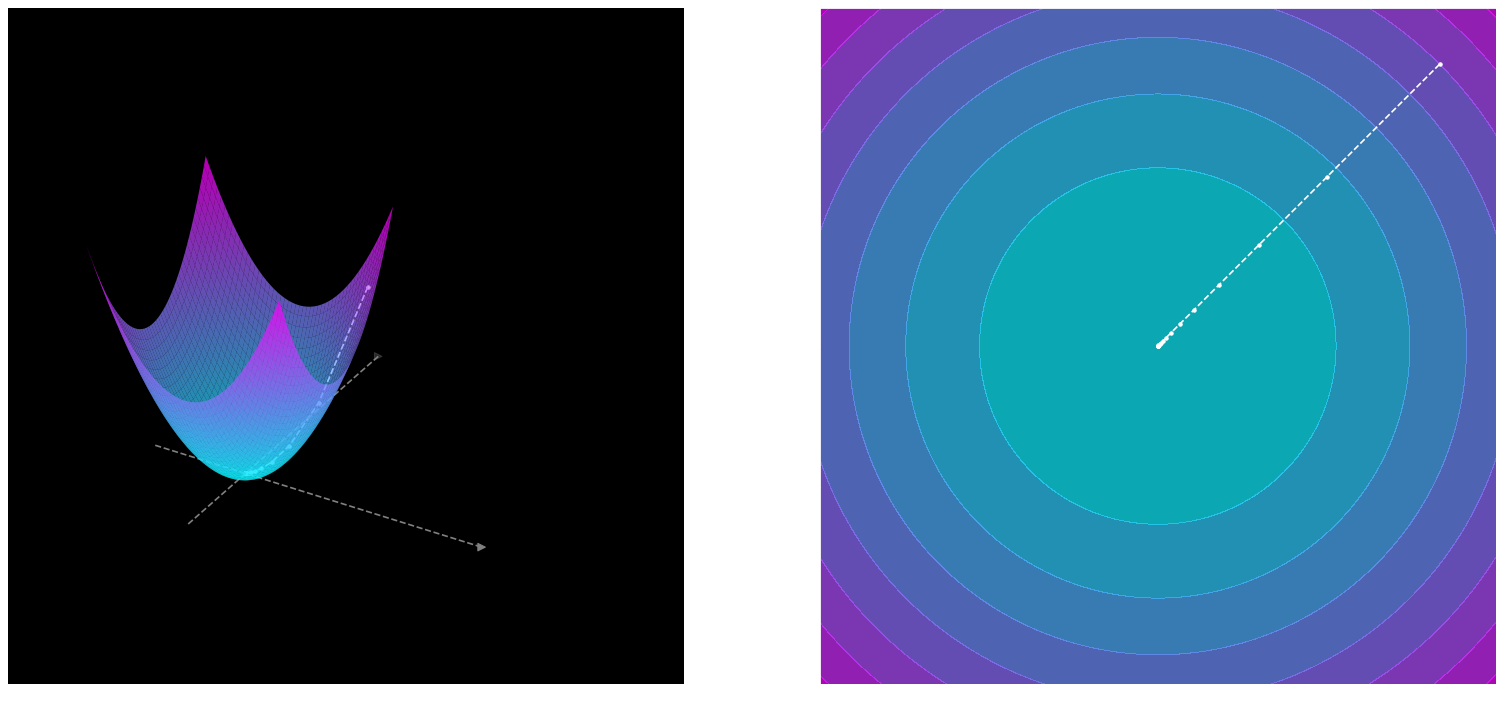

In [9]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.2)

### Large learning rate

Iterations: 65, result: [-5.52168163e-06 -5.52168163e-06  6.09779360e-11]


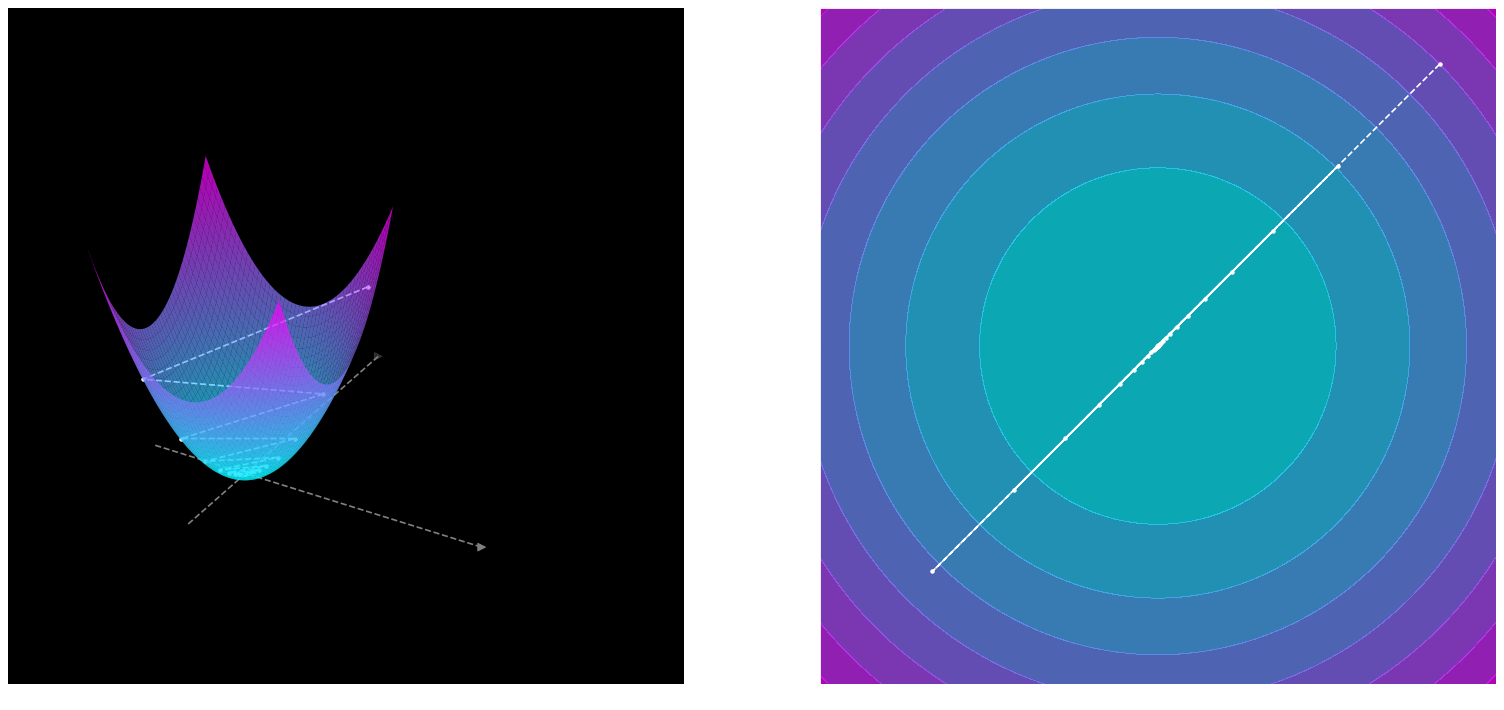

In [21]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.9)

### Small learning rate

Iterations: 100, result: [1.32619513 1.32619513 3.51758702]


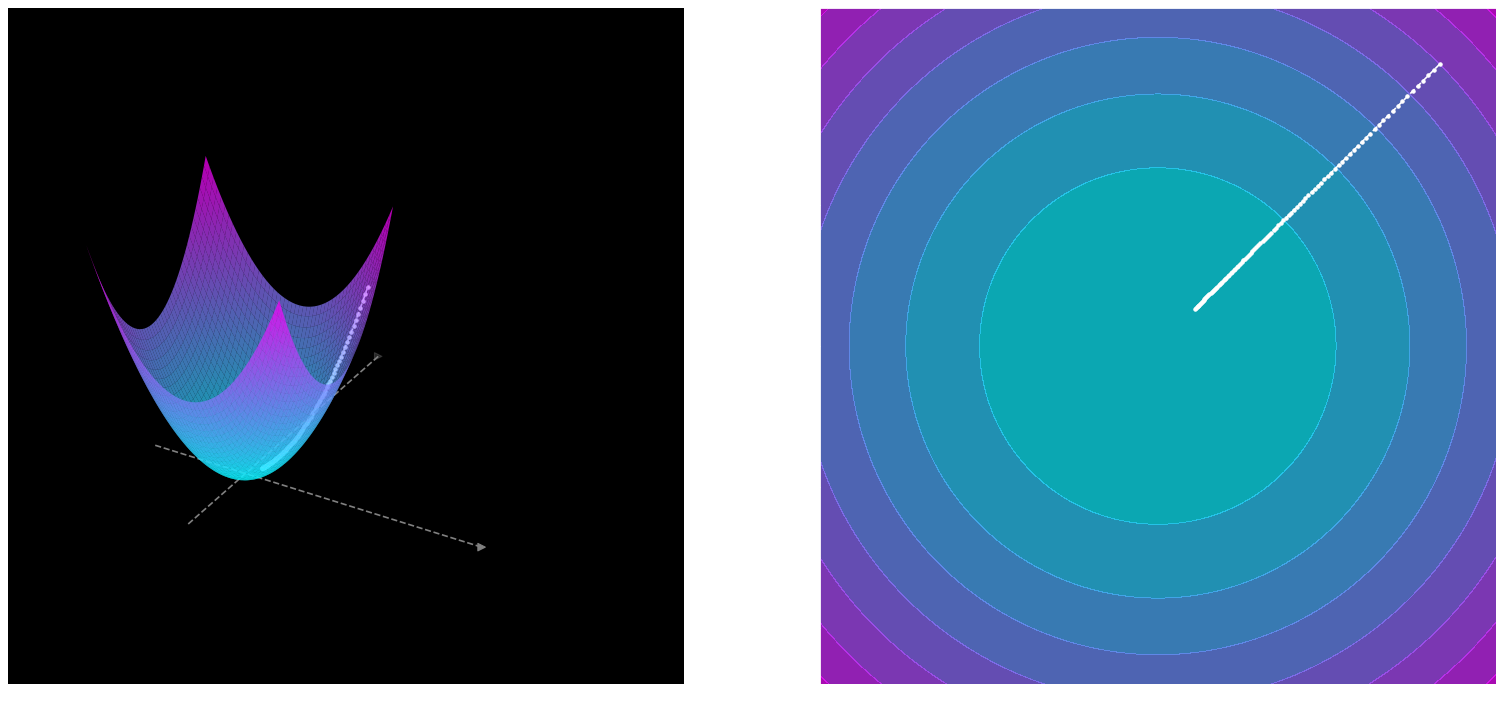

In [11]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.01)

## 2. Gradient descent with "step crushing" - метод дробления шага

$\displaystyle f(x_{k+1}) = f(x_k - \lambda_{k}\nabla f(x_k)) \leqslant f(x_k) - \varepsilon \lambda_{k} \Vert \nabla f(x_k) \Vert^2, \ \ \displaystyle \varepsilon \in (0, 1)$

False: $\lambda_k \rightarrow \frac{\lambda_k}{2}$

In [12]:
@painter_decorator3d
def gradient_descent_step_crushing(f, x0, learning_rate=1, tolerance=1e-6, n_iter=100, eps=0.1):
    xk = np.array([x0], dtype=float)
    fxk = f(x0)
    i, lr = 0, learning_rate
    while i < n_iter:
        step = lr * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        fxk1 = f(xk1)
        if fxk1 - fxk > -eps * lr * (np.linalg.norm(gradient(f, xk[-1]), 2) ** 2):
            lr *= .5
            continue

        xk = np.append(xk, np.array([xk1]), axis=0)
        fxk = fxk1
        lr = learning_rate
        i += 1
    return xk

Iterations: 38, result: [9.99999476e-01 2.99999948e+00 4.94396927e-12]


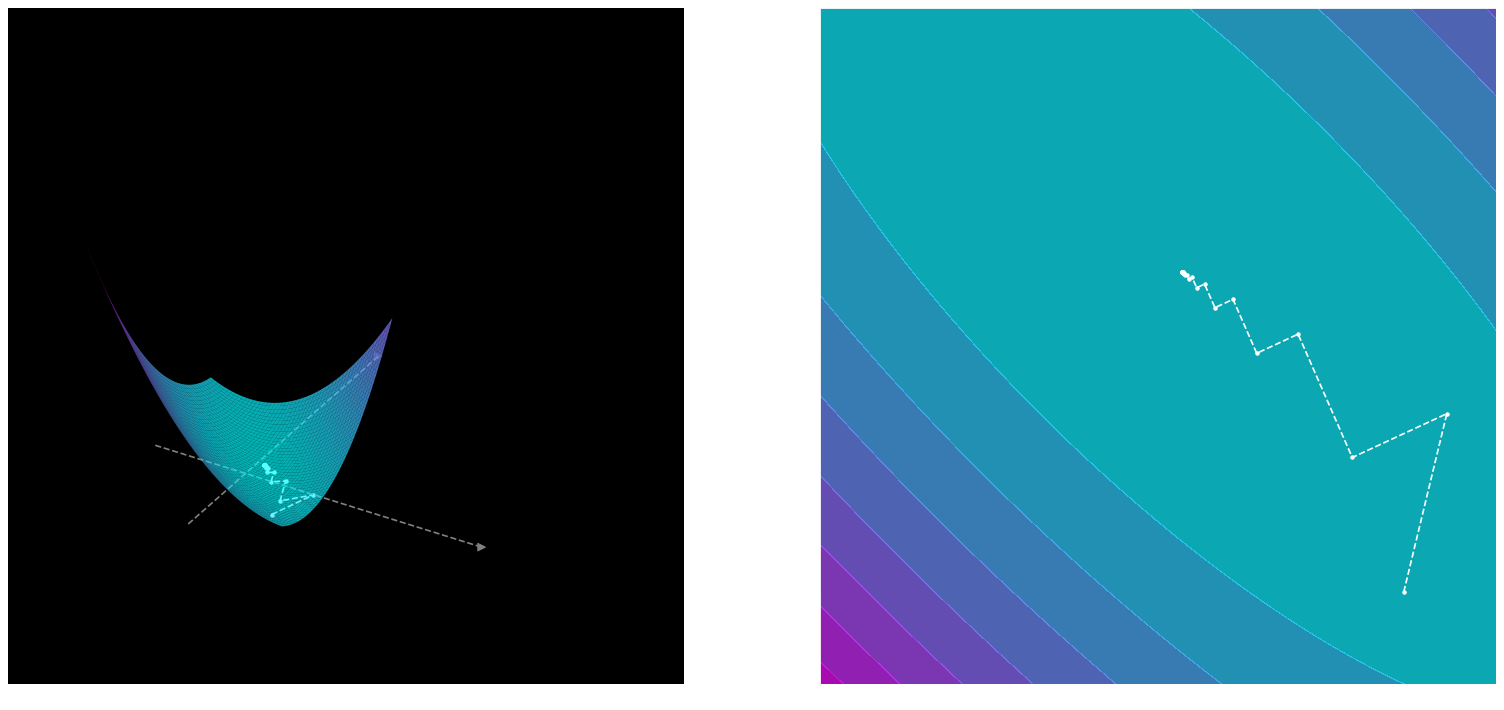

In [20]:
gradient_descent_step_crushing(f2, np.array([10, -10], dtype=float), 1)

## 3. Gradient descent with 1D optimization techniques

$\displaystyle \lambda_k = \arg_{\lambda \in [0, +\inf)} \min \ f(x_k - \lambda \nabla f(x_k))$

In [14]:
from opt_algo.opt_1d import *


@painter_decorator3d
def gradient_descent_opt1d(f, opt_method, x0, tolerance=1e-4, n_iter=100):
    xk = np.array([x0], dtype=float)
    l, r = 0, 1e6
    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * gradient(f, xk[-1])), l, r, eps=tolerance)
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)
    return xk

Iterations: 40, result: [1.00020684e+00 2.99970570e+00 1.59997107e-07]


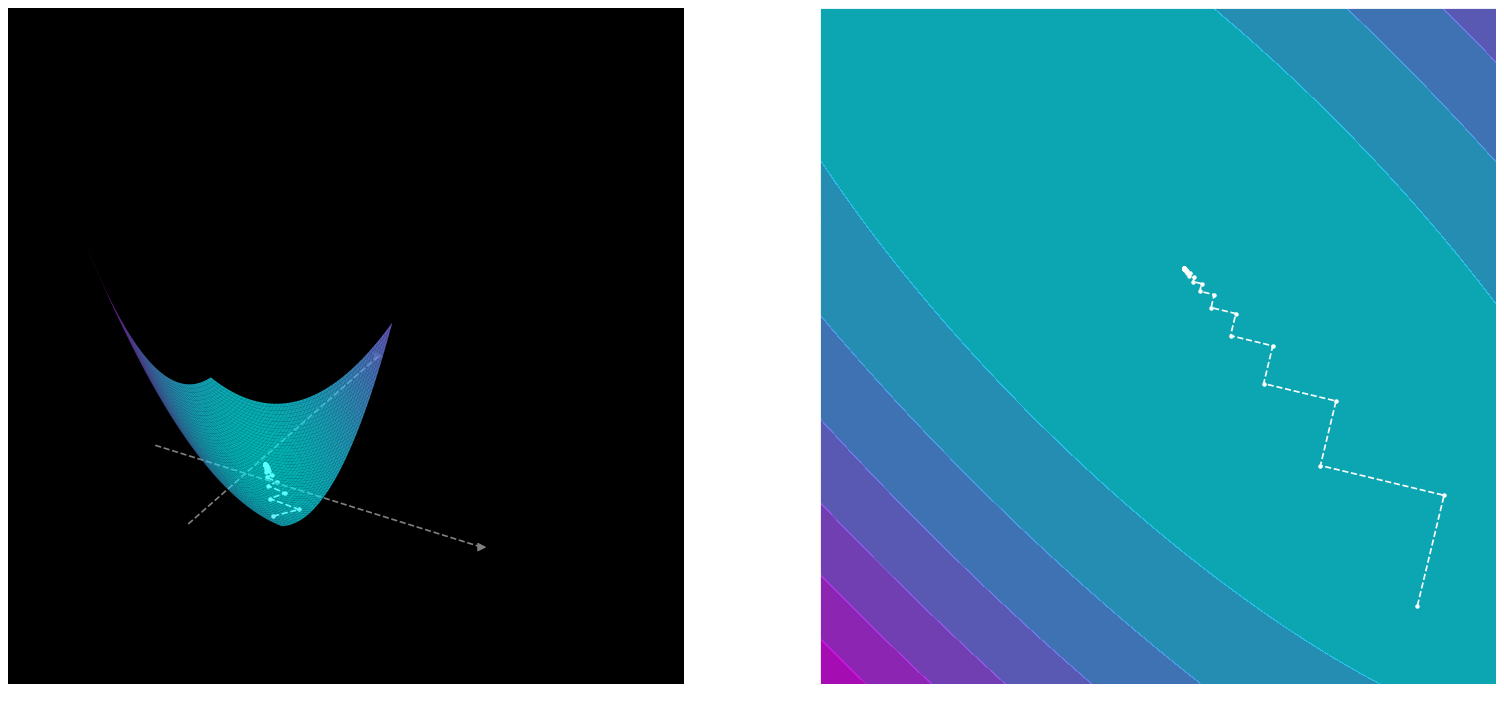

In [15]:
gradient_descent_opt1d(f2, golden_section_search, np.array([10, -10], dtype=float))

Iterations: 34, result: [9.99747441e-01 3.00016375e+00 1.22148524e-07]


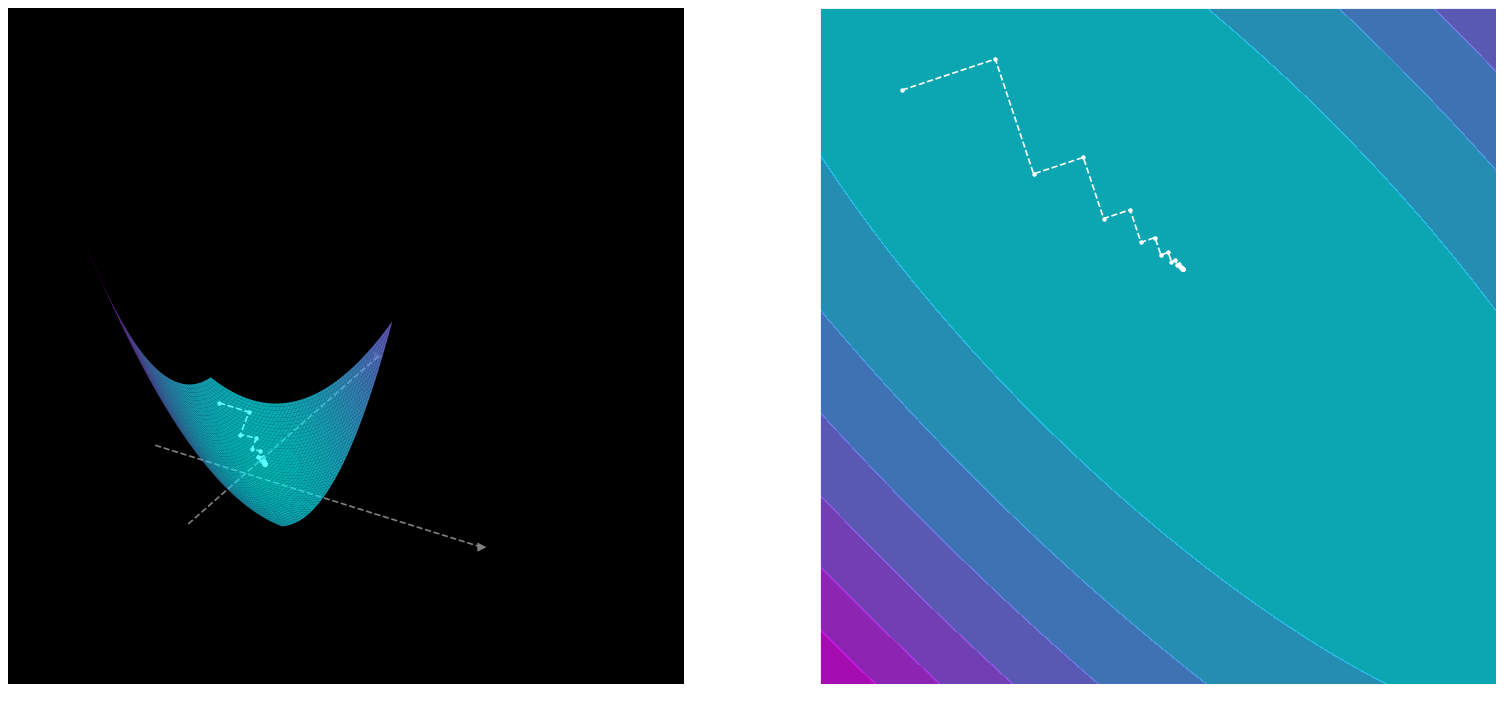

In [16]:
gradient_descent_opt1d(f2, golden_section_search, np.array([-10, 10], dtype=float))